In [1]:
from paretoCardinalityRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
def findApproximateParetoSolutionsRestaurants(simMatrix, item_ids, sample_size=None, num_runs=10, k_max=50, dataset_name=""):
    '''
    Run algorithms over multiple runs and plot mean +/- std (Objective vs Cardinality).
    Parameters:
    - simMatrix: Similarity matrix
    - item_ids: List of item ids (restaurants)
    - sample_size: Optional subsample size for items
    - num_runs: Number of independent runs
    - k_max: Maximum cardinality
    - dataset_name: Name of the dataset for plotting
    '''
    algo_names = ["C-Greedy", "TopK", "Random"]

    # Subsample items if requested
    n_items = len(item_ids)
    if sample_size is None or sample_size <= 0 or sample_size >= n_items:
        selected_indices = np.arange(n_items)
    else:
        rng = np.random.default_rng()
        selected_indices = rng.choice(n_items, size=sample_size, replace=False)
    selected_indices = np.sort(selected_indices)
    sub_items = [item_ids[i] for i in selected_indices]
    sub_sim = simMatrix[np.ix_(selected_indices, selected_indices)]

    # containers across runs
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}

    for _ in range(num_runs):
        run_objectives = {alg: [] for alg in algo_names}
        run_runtimes = {alg: [] for alg in algo_names}

        # C-Greedy (formerly ParetoGreedy-Cardinality)
        pareto = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto.paretoGreedy()
        objectives = [pareto.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['C-Greedy'] = objectives
        run_runtimes['C-Greedy'] = runTime

        # Top K
        pareto2 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto2.top_k()
        objectives = [pareto2.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['TopK'] = objectives
        run_runtimes['TopK'] = runTime

        # Random
        pareto3 = paretoCardinalityRestaurants(n_items=sub_items, simMatrix=sub_sim, k_max=k_max)
        _, _, _, runTime = pareto3.random_selection()
        objectives = [pareto3.kSolDict.get(k, {'Objective': 0})['Objective'] for k in range(1, k_max + 1)]
        run_objectives['Random'] = objectives
        run_runtimes['Random'] = runTime

        # store per-run arrays and total runtimes
        for alg in algo_names:
            arr = np.array(run_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros(k_max, dtype=float)
            all_objectives[alg].append(arr)
            all_runtimes[alg].append(run_runtimes[alg])

    # compute mean and std across runs for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (num_runs, k_max)
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0)

    # Plot mean objective with shaded std band (match cardinality teams formatting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "Random": tab10_colors[7],
    }
    marker_map = {
        "TopK": "o",
        "C-Greedy": "^",
        "Random": "s",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "C-Greedy": (0, (3, 2)),
        "Random": (0, (2, 2)),
    }
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        marker_size = 7
        line_style = linestyle_map.get(alg, (0, (1, 1)))
        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        ax.plot(range(1, k_max + 1), mean,
                label=rf"\texttt{{{alg}}}",
                color=color,
                linestyle=line_style,
                marker=marker,
                markersize=marker_size,
                markevery=3,
                markeredgewidth=1.1,
                markeredgecolor='k',
                linewidth=1.8,
                zorder=zorder)
        ax.fill_between(range(1, k_max + 1),
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)
    
    ax.set_xlabel(r'Cardinality, $k$', fontsize=28)
    ax.set_ylabel(r'Objective, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)
    
    # Legend handles (saved separately)
    handles, labels = ax.get_legend_handles_labels()
    
    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "cardinality"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_cardinality.pdf"
    fig.savefig(out_path, bbox_inches="tight")
    
    # Save legend as separate PDF
    if handles:
        legend_out_path = plots_dir / "cardinality_legend.pdf"
        if not legend_out_path.exists():
            legend_fig = plt.figure(figsize=(8, 2))
            legend_fig.legend(handles, labels, loc='center', ncol=3, fontsize=22, frameon=True)
            legend_fig.savefig(legend_out_path, bbox_inches="tight")
            plt.close(legend_fig)
    
    plt.show()
    
    # Runtime summary (mean ± std)
    runtime_lines = ["Runtime summary (mean ± std, seconds):"]
    for alg in algo_names:
        mean_rt = float(np.mean(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        std_rt = float(np.std(all_runtimes[alg])) if len(all_runtimes[alg]) > 0 else 0.0
        runtime_lines.append(f"  - {alg}: {mean_rt:.3f} ± {std_rt:.3f}")
    logging.info("\n".join(runtime_lines))
    
    return None

### Yelp Phoenix Experiments

In [3]:
#Import Yelp Phoenix dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

2026-02-07 17:53:55,463 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:1000, k_max=400
2026-02-07 17:55:56,164 |INFO: Cardinality Greedy Solution:[506, 904, 129, 954, 522, 274, 29, 874, 545, 198, 642, 44, 168, 638, 441, 926, 933, 80, 461, 468, 564, 367, 98, 787, 636, 379, 699, 79, 364, 624, 591, 75, 599, 556, 13, 55, 314, 276, 243, 313, 847, 410, 219, 244, 865, 113, 257, 173, 85, 817, 408, 250, 247, 101, 146, 174, 849, 834, 792, 72, 344, 372, 148, 557, 822, 914, 701, 483, 114, 352, 759, 212, 633, 672, 45, 438, 70, 82, 130, 172, 369, 404, 689, 147, 425, 295, 618, 117, 725, 814, 637, 164, 871, 220, 256, 142, 966, 533, 897, 944, 260, 887, 829, 222, 403, 844, 426, 916, 868, 273, 62, 901, 880, 460, 335, 188, 808, 550, 549, 981, 323, 913, 895, 218, 757, 687, 456, 102, 717, 338, 625, 470, 23, 614, 1, 418, 783, 845, 679, 479, 998, 851, 27, 836, 688, 46, 983, 40, 900, 766, 83, 278, 30, 524, 136, 494, 507, 159, 454, 73, 253, 908, 471, 111, 171, 459, 833, 393, 3

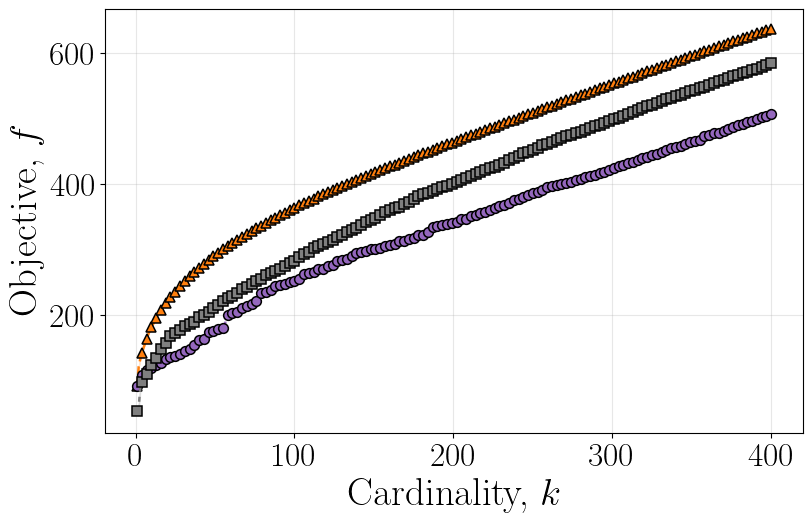

2026-02-07 18:00:48,365 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 120.643 ± 0.056
  - TopK: 54.366 ± 0.013
  - Random: 31.016 ± 0.181


In [4]:
# Adjust parameters as needed
sample_size = 1000
num_runs = 2  # number of random runs
k_max = 400
findApproximateParetoSolutionsRestaurants(phoenix_simMatrix, phoenix_ids, sample_size, num_runs, k_max, "Yelp_Phoenix")

### Yelp Vegas Experiments

In [5]:
#Import Yelp Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

2026-02-07 18:00:48,476 |INFO: Initialized Pareto Restaurant - Cardinality Constraint Instance, Num Items:1500, k_max=400
2026-02-07 18:05:28,547 |INFO: Cardinality Greedy Solution:[100, 1091, 114, 1254, 870, 424, 1001, 1355, 480, 861, 378, 191, 1131, 928, 768, 1223, 464, 573, 166, 439, 765, 74, 469, 87, 1049, 226, 404, 329, 1411, 1122, 793, 1028, 1273, 410, 112, 368, 30, 732, 1090, 593, 304, 824, 1000, 137, 7, 315, 977, 3, 364, 448, 1141, 221, 641, 451, 1145, 969, 1207, 18, 255, 241, 398, 370, 393, 1066, 1405, 1433, 743, 308, 186, 269, 93, 1282, 1012, 553, 512, 588, 912, 115, 804, 66, 336, 563, 236, 611, 1147, 295, 433, 603, 405, 672, 1130, 959, 665, 889, 559, 1452, 142, 248, 1165, 1283, 1200, 557, 171, 306, 102, 575, 1483, 1133, 1294, 590, 331, 441, 143, 539, 77, 1351, 922, 520, 372, 1211, 6, 244, 506, 851, 1288, 949, 780, 36, 856, 1085, 60, 1275, 1420, 604, 724, 756, 261, 1291, 1432, 867, 917, 1075, 903, 501, 472, 456, 986, 1391, 267, 1337, 580, 126, 767, 1306, 1289, 282, 924, 1301,

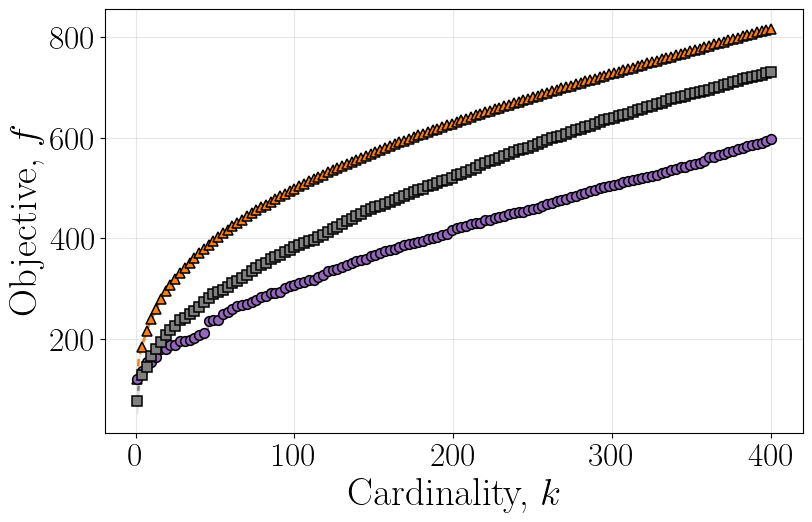

2026-02-07 18:14:17,072 |INFO: Runtime summary (mean ± std, seconds):
  - C-Greedy: 277.991 ± 2.078
  - TopK: 79.945 ± 0.215
  - Random: 46.234 ± 0.015


In [6]:
# Adjust parameters as needed
sample_size = 1500
num_runs = 2  # number of random runs
k_max = 400
findApproximateParetoSolutionsRestaurants(vegas_simMatrix, vegas_ids, sample_size, num_runs, k_max, "Yelp_Vegas")